### DSE203 -  Demand Prediction - Machine Learning Team
**Suman, Anil, Chris, Tony, Kyle**

Notebook to validate data, build & persist models, and display information about the models.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import pickle

#### We've previously shown 4 supercategories. We'll make a regression model for each category.

In [9]:
# Here are the supercategories for the top 75 nodeIDs as determined by EDA
# http://localhost:8888/notebooks/Documents/DSE203/EDA%20Supercategories.ipynb
df_supercat = pd.read_csv('supercategories.csv') #mappings
df_supercat = df_supercat.drop(df_supercat.columns[0], axis=1)
df_supercat['Supercategory'] += 1  # Add 1 so that supercategories are indexed from 1 not 0.

In [13]:
df_supercat.sample(10)

,NodeID,Supercategory
71,8883864011,4
45,8883852011,2
44,7009088011,2
62,282838,3
26,3612,2
18,3131,2
33,13682,2
56,2963,3
17,3122,2
36,882340,2


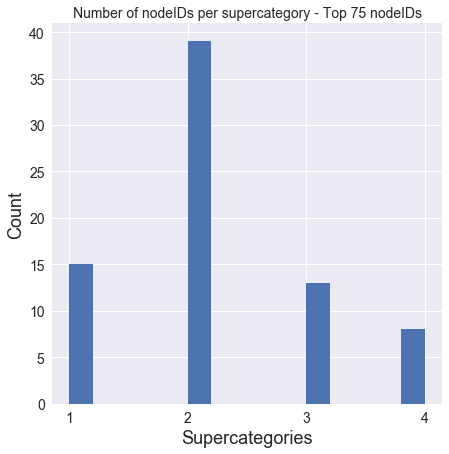

In [20]:
plt.figure(figsize=(7,7));
df_supercat['Supercategory'].hist(bins=15);
plt.xticks([1,2,3,4], [1,2,3,4], fontsize=14);
plt.yticks(fontsize=14);
plt.xlabel('Supercategories', fontsize=18);
plt.ylabel('Count', fontsize=18);
plt.title('Number of nodeIDs per supercategory - Top 75 nodeIDs', fontsize=14);

## Load the data from the data sources

We've taken the top 75 categories by total sales. The query team has pulled out the aggregated data based on this datalog query. We've saved it to CSV files just to work offline.

In [43]:
# Creating data models for each supercategory
# adding these models to a list
# Also need to sort the values by year then month so that we can use walk forward cross-validation

df_list = {}
for category in range(1,5):
    df = pd.read_csv('jit_data/ML_feat_cat{}.csv'.format(category))
    df = df.drop(df.columns[0], axis=1)
    df = df.sort_values(['yr', 'mon']) # Sort by date and time
    df = df[df['yr'] != df['yr'].max()]
    df_list[category] = df

In [44]:
df_list.keys() # 4 data models

[1, 2, 3, 4]

In [45]:
df_list[1]

,nodeid,mon,yr,total_sales_volume,total_sales_price,pm_total_sales_volume,pm_total_sales_price,l3m_total_sales_volume,l3m_total_sales_price,l12m_total_sales_volume,l12m_total_sales_price,numreviews_by_period,avgrating_by_period,numreviews,avgrating
92,3179,12.0,2009.0,5,39.75,0,0.00,0,0.00,0,0.00,0.0,0.0,2.0,4.50
95,3179,1.0,2010.0,0,0.00,5,39.75,5,39.75,5,39.75,0.0,0.0,2.0,4.50
68,3179,3.0,2010.0,1,7.95,0,0.00,5,39.75,5,39.75,0.0,0.0,2.0,4.50
382,8622832011,3.0,2010.0,54,9620.75,0,0.00,0,0.00,0,0.00,0.0,0.0,1.0,5.00
71,3179,4.0,2010.0,186,3030.33,1,7.95,1,7.95,6,47.70,0.0,0.0,2.0,4.50
389,8622832011,4.0,2010.0,188,33615.75,54,9620.75,54,9620.75,54,9620.75,0.0,0.0,1.0,5.00
74,3179,5.0,2010.0,131,1968.12,186,3030.33,187,3038.28,192,3078.03,0.0,0.0,2.0,4.50
396,8622832011,5.0,2010.0,152,27140.75,188,33615.75,242,43236.50,242,43236.50,0.0,0.0,1.0,5.00
76,3179,6.0,2010.0,222,4258.25,131,1968.12,318,5006.40,323,5046.15,0.0,0.0,2.0,4.50
403,8622832011,6.0,2010.0,191,32330.75,152,27140.75,394,70377.25,394,70377.25,0.0,0.0,1.0,5.00


In [46]:
df_list[1].sample(10) #sample data from super category 1

,nodeid,mon,yr,total_sales_volume,total_sales_price,pm_total_sales_volume,pm_total_sales_price,l3m_total_sales_volume,l3m_total_sales_price,l12m_total_sales_volume,l12m_total_sales_price,numreviews_by_period,avgrating_by_period,numreviews,avgrating
266,171114,9.0,2014.0,352,8424.85,279,6613.15,2787,67465.39,3526,85409.23,0.0,0.0,4.0,4.75
252,171114,4.0,2015.0,62,1520.75,155,2563.48,495,6564.33,6097,140269.41,0.0,0.0,4.0,4.75
223,3939,6.0,2014.0,78,1090.22,82,869.81,258,2988.53,369,4696.73,0.0,0.0,28.0,4.43
424,8622832011,9.0,2010.0,32,4670.00,54,8630.75,371,62136.50,765,132513.75,0.0,0.0,1.0,5.00
146,3214,3.0,2011.0,21,410.97,0,0.00,0,0.00,0,0.00,0.0,0.0,5.0,5.00
242,3939,12.0,2014.0,125,1674.09,216,1344.93,355,2898.28,884,9726.72,0.0,0.0,28.0,4.43
448,8622832011,1.0,2012.0,5,869.20,10,1830.00,22,4004.20,140,23900.90,0.0,0.0,1.0,5.00
312,132561011,12.0,2014.0,75,3893.99,56,2913.67,164,8165.64,672,34568.94,0.0,0.0,44.0,4.14
14,2950,4.0,2015.0,5,55.71,2,195.00,8,612.60,65,2435.38,0.0,0.0,7.0,3.57
208,3263,12.0,2014.0,0,0.00,1,26.95,4,86.85,304,8964.20,0.0,0.0,2.0,3.00


## Don't trust data on the end years

The data has come back without nulls. So 0 and null are mixed. We think the 0's in the last year of the data are actually null (unknown) so it would be wrong to predict them as 0. Therefore we set df's to: 
    
    df[df['yr'] != df['yr'].max()]

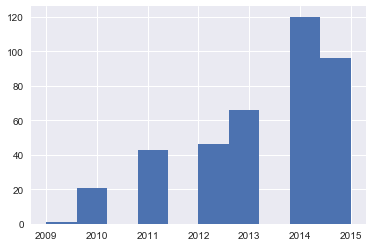

In [47]:
df_list[1]['yr'].hist();

In [52]:
model_selector = widgets.Dropdown(
   options=[1,2,3,4],
   description='Data Model:',
   disabled=False
)
display(model_selector)

In [101]:
# Select the supercategory data from above to use for building a model
df = df_list[model_selector.value] 

In [102]:
features = df.iloc[:, 5:]
features['month'] = df.iloc[:,1]

predictions = df.iloc[:,3]

In [103]:
y_log_tr = predictions.apply(lambda el: 0 if el == 0 else np.log10(el))

In [104]:
features_np = features.as_matrix()
predictions_np =y_log_tr.as_matrix()

In [105]:
#training based on log transform from previous cells
#log transform fits the data into a more normalized guassian distribution 

num_test = df.shape[0]//3
X_train = features.iloc[:-num_test,:]
y_train = y_log_tr.iloc[:-num_test]
X_test = features.iloc[-num_test:,:]
y_test = y_log_tr.iloc[-num_test:]


# Fit the model to the training data

Here we use Gradient Boosted Regression trees. In the initial pass we used GridSearchCV to perform a 3-fold cross-validation grid search of the hyperparameters (e.g. number of leaves, learning rate, number of features). Once we found the best hyperparameters for each model, we will stick with them in future training.

There is a parameter called 'init' which is supposed to pass in any previously-trained regression model. The idea is that every time we train the model, then we can use the previously trained model as the starting point for the new model. Therefore, the only data we need to access is the data that was not included in the previous models. This will greatly help in scalability of the system. NOTE: There seems to be some current bug in sklearn for this. I believe XGBoost has the same procedure for performing online, batch updates of the regression model.

In [106]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

## Train/Test Split

The GridSearchCV will do the train/validation split for us. Let's set aside the last 1/3 of the data (by time) as the test data.

In [107]:

num_test = df.shape[0]//3
X_train = features.iloc[:-num_test,:]
y_train = y_log_tr.iloc[:-num_test]
X_test = features.iloc[-num_test:,:]
y_test = y_log_tr.iloc[-num_test:]


## Perform the grid search

## Report the best hyperparameters for this model.

## Best hyperparameters per supercategory

Most of the models use the same hyperparameters. Now that we have found them we can comment out the GridSearch code and just specify the parameters manually.

In [108]:
#note optimal params are sim among 4 super categories
params1 = {'learning_rate': 0.005, 'loss': 'huber',
           'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 2,
           'n_estimators': 1500}

params2 = {'learning_rate': 0.01, 'loss': 'huber', 'max_depth': 4, 
           'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}

params3 = {'learning_rate': 0.01, 'loss': 'huber',
           'max_depth': 2, 'max_features': 'log2', 
           'min_samples_split': 2, 'n_estimators': 500}

params4 = {'learning_rate': 0.005, 'loss': 'huber',
           'max_depth': 2, 'max_features': 'log2', 
           'min_samples_split': 2, 'n_estimators': 500}

# Load the best hyperparameters for this supercategory
if (sc==1):
        params = params1
elif (sc==2):
    params = params2
elif (sc==3):
    params = params3
elif (sc==4):
    params = params4
    
clf = ensemble.GradientBoostingRegressor(**params)

## Walk forward time series split

This does the walk forward method to determine how well the model does as a function of time. We have chosen 5 sequential splits of the time series (based on the 5 years of data).

In [109]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

In [110]:

for train_index, test_index in tscv.split(features_np):
    
    X_train, X_test = features_np[train_index], features_np[test_index]
    y_train, y_test = predictions_np[train_index], predictions_np[test_index]
    
    clf.fit(X_train, y_train)
    
    print(clf.score(X_test, y_test))

0.589658898197
0.262606318731
0.53168699
0.345210228587
0.584815726476


## Save the model to pickle file

In [111]:
# model persistence


def persist_model(model_name,super_cat_name,date,model):
    """
    model and super category name do not have blank spaces
    date in the form: yyyymmdd
    model is a valid scikit learn class instance
    """

    underscore = '_'
    seq = (model_name,super_cat_name,date)
    filename = underscore.join([str(x) for x in seq]).replace(" ","")

    pkl_model = open('models/' + filename, 'wb')
    pickle.dump(model, pkl_model)
    pkl_model.close()

In [112]:
name = 'GBR'
super_cat = str(model_selector.value)
date = '20171202'
model = clf
persist_model(name,super_cat,date,model)

# Evaluate the model against the test data

In [99]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

Median: -10.5 books off on the prediction.
Mean: 24.5 books off on the prediction.
Standard deviation of 152.73 books


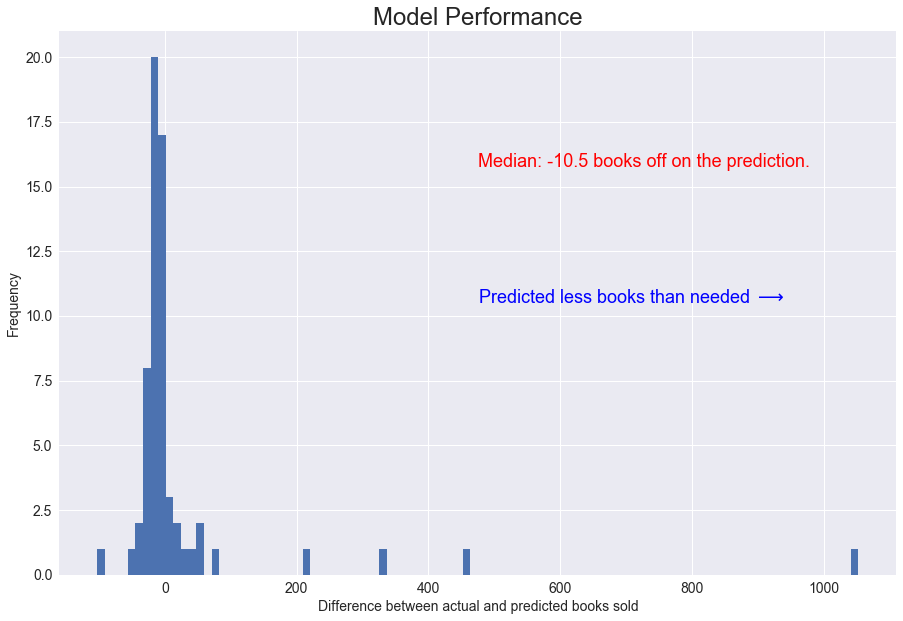

In [100]:
y_hat = clf.predict(X_test)

ax = plt.figure(figsize=(15,10))
plt.hist(10**y_test-10**y_hat, bins=100);
plt.title('Model Performance', fontsize=24);
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.xlabel('Difference between actual and predicted books sold', fontsize=14);
plt.ylabel('Frequency', fontsize=14);
plt.annotate('Median: {:.1f} books off on the prediction.'.format(np.median(10**y_test-10**y_hat)), 
             xy=(0.5, 0.75), xycoords='axes fraction', fontsize=18, color='red')
plt.annotate(r'Predicted less books than needed $\longrightarrow$', 
             xy=(0.5, 0.5), xycoords='axes fraction', fontsize=18, color='blue')
print('Median: {:.1f} books off on the prediction.'.format(np.median(10**y_test-10**y_hat)))
print('Mean: {:.1f} books off on the prediction.'.format(np.mean(10**y_test-10**y_hat)))
print('Standard deviation of {:.2f} books'.format(np.std(10**y_test-10**y_hat)))

Explained variance = 0.504
Mean squared error = 0.3033
Mean absolute error = 2.8888
r-squared = 0.494


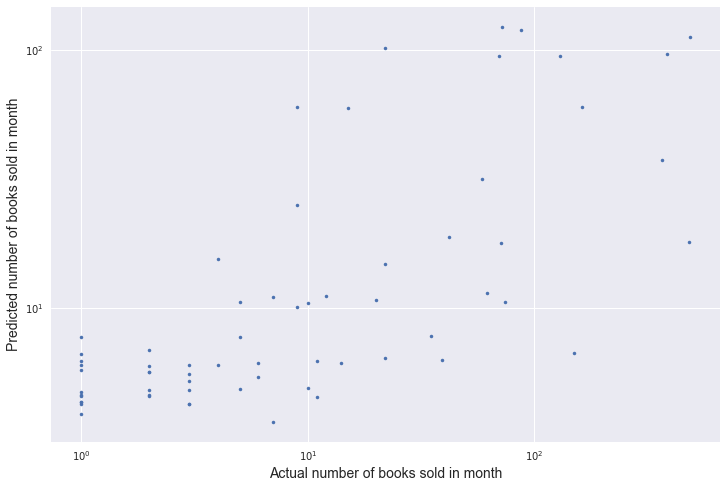

In [72]:
y_hat = clf.predict(X_test)

mse = mean_squared_error(y_test, y_hat)
mae = mean_absolute_error(y_test, y_hat)

plt.figure(figsize=(12,8))
plt.loglog(10**y_test, 10**y_hat, '.')
plt.xlabel('Actual number of books sold in month', fontsize=14)
plt.ylabel('Predicted number of books sold in month', fontsize=14)
print('Explained variance = {:.3f}'.format(explained_variance_score(y_test, y_hat)))
print('Mean squared error = {:.4f}'.format(mse))
print('Mean absolute error = {:.4f}'.format(10**mae))
print('r-squared = {:.3f}'.format(clf.score(X_test, y_test)))

# Training and Testing Mean Squared Error as a function of Iteration

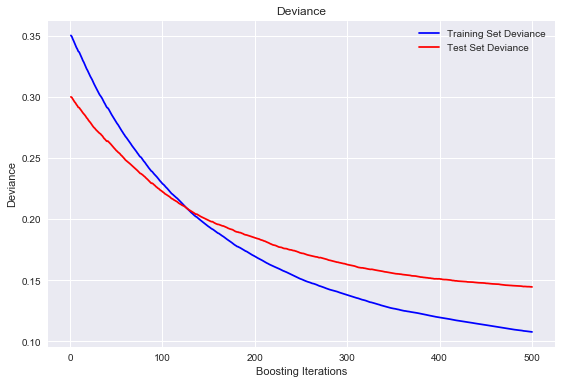

In [73]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance');

# Relative Importance of Different Features

This approach will allow us to weight the relative importance of different features to the regression.  This will help us to explain the model to the client in relatively simple terms. For example, we can say things like "The important features to predicting the number of sales are price, recent sentiment about the book, and the last 4 months of sales."

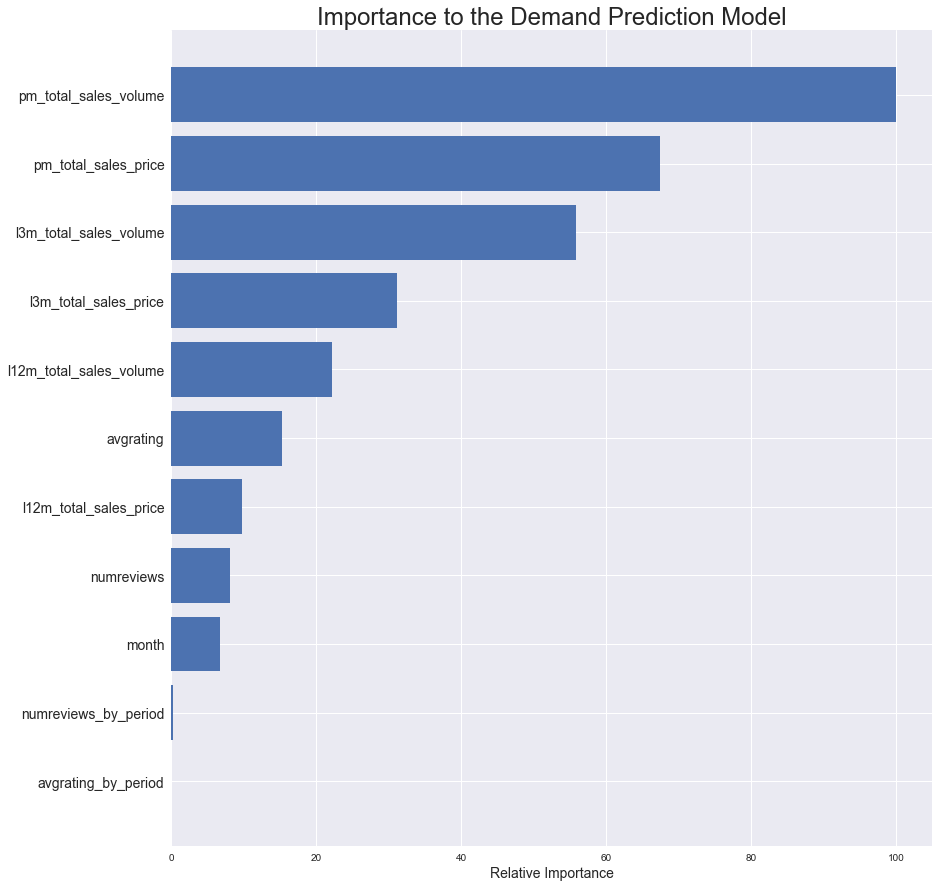

In [74]:

feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(30,15))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')

labels = features.columns

plt.yticks(pos, labels[sorted_idx], fontsize=14)
plt.xlabel('Relative Importance', fontsize=14)
plt.title('Importance to the Demand Prediction Model', fontsize=24)
plt.show()

## So reviews and rating information are typically less important to the model than the total sales over time.


In [ ]:
# import pickle

# # Save to file in the current working directory
# pkl_filename = "pickle_model{}.pkl".format(sc) 
# with open(pkl_filename, 'wb') as file:  
#     pickle.dump(clf, file)